<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Reading-the-data" data-toc-modified-id="Reading-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading the data</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Undersampling" data-toc-modified-id="Undersampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Undersampling</a></span></li><li><span><a href="#Oversampling" data-toc-modified-id="Oversampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Oversampling</a></span></li></ul></li></ul></div>

On the problem context of creating a model to predict fraudulent transactions base on the use of credit card, we have a dataset showing us details of these transactions realized during two days of September 2013 in Europe. The data collected has 492 frauds itentified among 284,807 transactions, so this is a really unbalanced data as long as only 0.172% of all the transactions available are really frauds.

Beyond this, we have 30 features where 28 of them are generated by some dimensionality reduction step (Principal Componente Analysis - PCA) and by security, the provider didn't specified the meaning of those features. So the other 2 can be defined as:

* **Time:** Seconds between each transaction and the first one;
* **Amount:** Transaction's value.

For the evaluation metric it's recommended to use AUC (Are Under the Curve ROC), as long as we have a really unbalanced dataset and on those cases it's not good to use standard metrics like accuracy or the confusion matrix itself. In this case we will go deep into models probabilities.

By the end, if you like this kernel, please **upvote!**

# Libraries

In [1]:
# Stsandard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time

# Utilities
from utils.viz_utils import *
from utils.ml_utils import *
from utils.custom_transformers import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, \
                                    learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
    accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Reading the data

Let's first read the data withing a optimized approach (low memory usage)

In [2]:
# Data path
path = r'D:\Users\thiagoPanini\Downloads\Datasets\kgl_CreditCard_FraudDetection'
df_ori = import_data(path + r'\creditcard.csv', optimized=True)
df_ori.columns = [col.lower() for col in df_ori.columns]

# Results
print(f'Data dimension: {df_ori.shape}')
df_ori.head()

O dataset possui 31 colunas, das quais 31 são elegíveis a otimização.

----------------------------------------------------
Memória RAM utilizada (50 linhas): 0.0119 MB
Memória RAM após otimização (50 linhas): 0.0060 MB
----------------------------------------------------

Ganho de 50.32% em uso de memória!

Data dimension: (284807, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


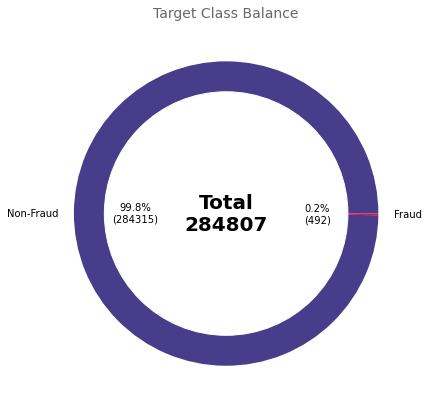

In [3]:
# Target class balance
fig, ax = plt.subplots(figsize=(7, 7))
label_names = ['Non-Fraud', 'Fraud']
color_list = ['darkslateblue', 'crimson']
text = f'Total\n{len(df_ori)}'
title = 'Target Class Balance'

# Visualizing it through a donut chart
donut_plot(df_ori, col='class', ax=ax, label_names=label_names, colors=color_list, title=title, text=text)

___
* _Complete overview of each feature_
___

In [4]:
df_overview = data_overview(df_ori, corr=True, label_name='class')
df_overview.head(20)

,feature,qtd_null,percent_null,dtype,qtd_cat,target_pearson_corr
0,time,0,0.0,int32,0,-0.012323
1,v16,0,0.0,float32,0,-0.196539
2,amount,0,0.0,float32,0,0.005632
3,v28,0,0.0,float32,0,0.009536
4,v27,0,0.0,float32,0,0.017580
5,v26,0,0.0,float32,0,0.004455
6,v25,0,0.0,float32,0,0.003308
7,v24,0,0.0,float32,0,-0.007221
8,v23,0,0.0,float32,0,-0.002685
9,v22,0,0.0,float32,0,0.000805


___
* _Target correlation (positive and negative)_
___

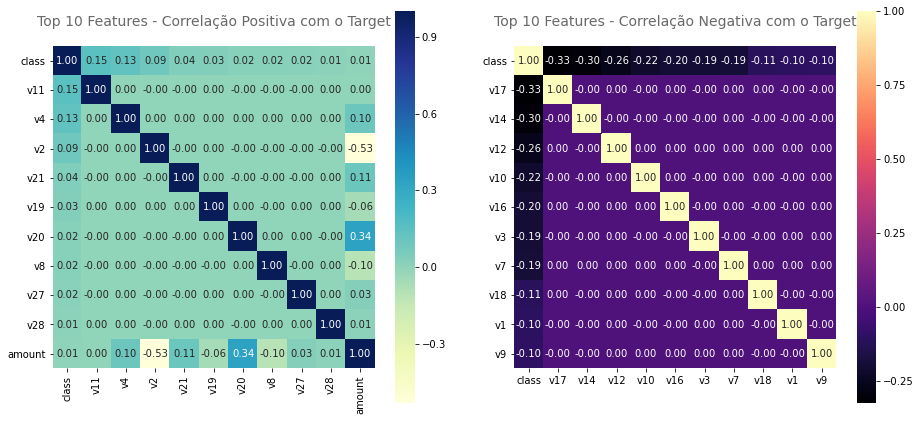

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
target_correlation_matrix(data=df_ori, label_name='class', corr='positive', ax=axs[0])
target_correlation_matrix(data=df_ori, label_name='class', corr='negative', ax=axs[1])

plt.tight_layout()
plt.show()

___
* _Numerical features distribution_
___

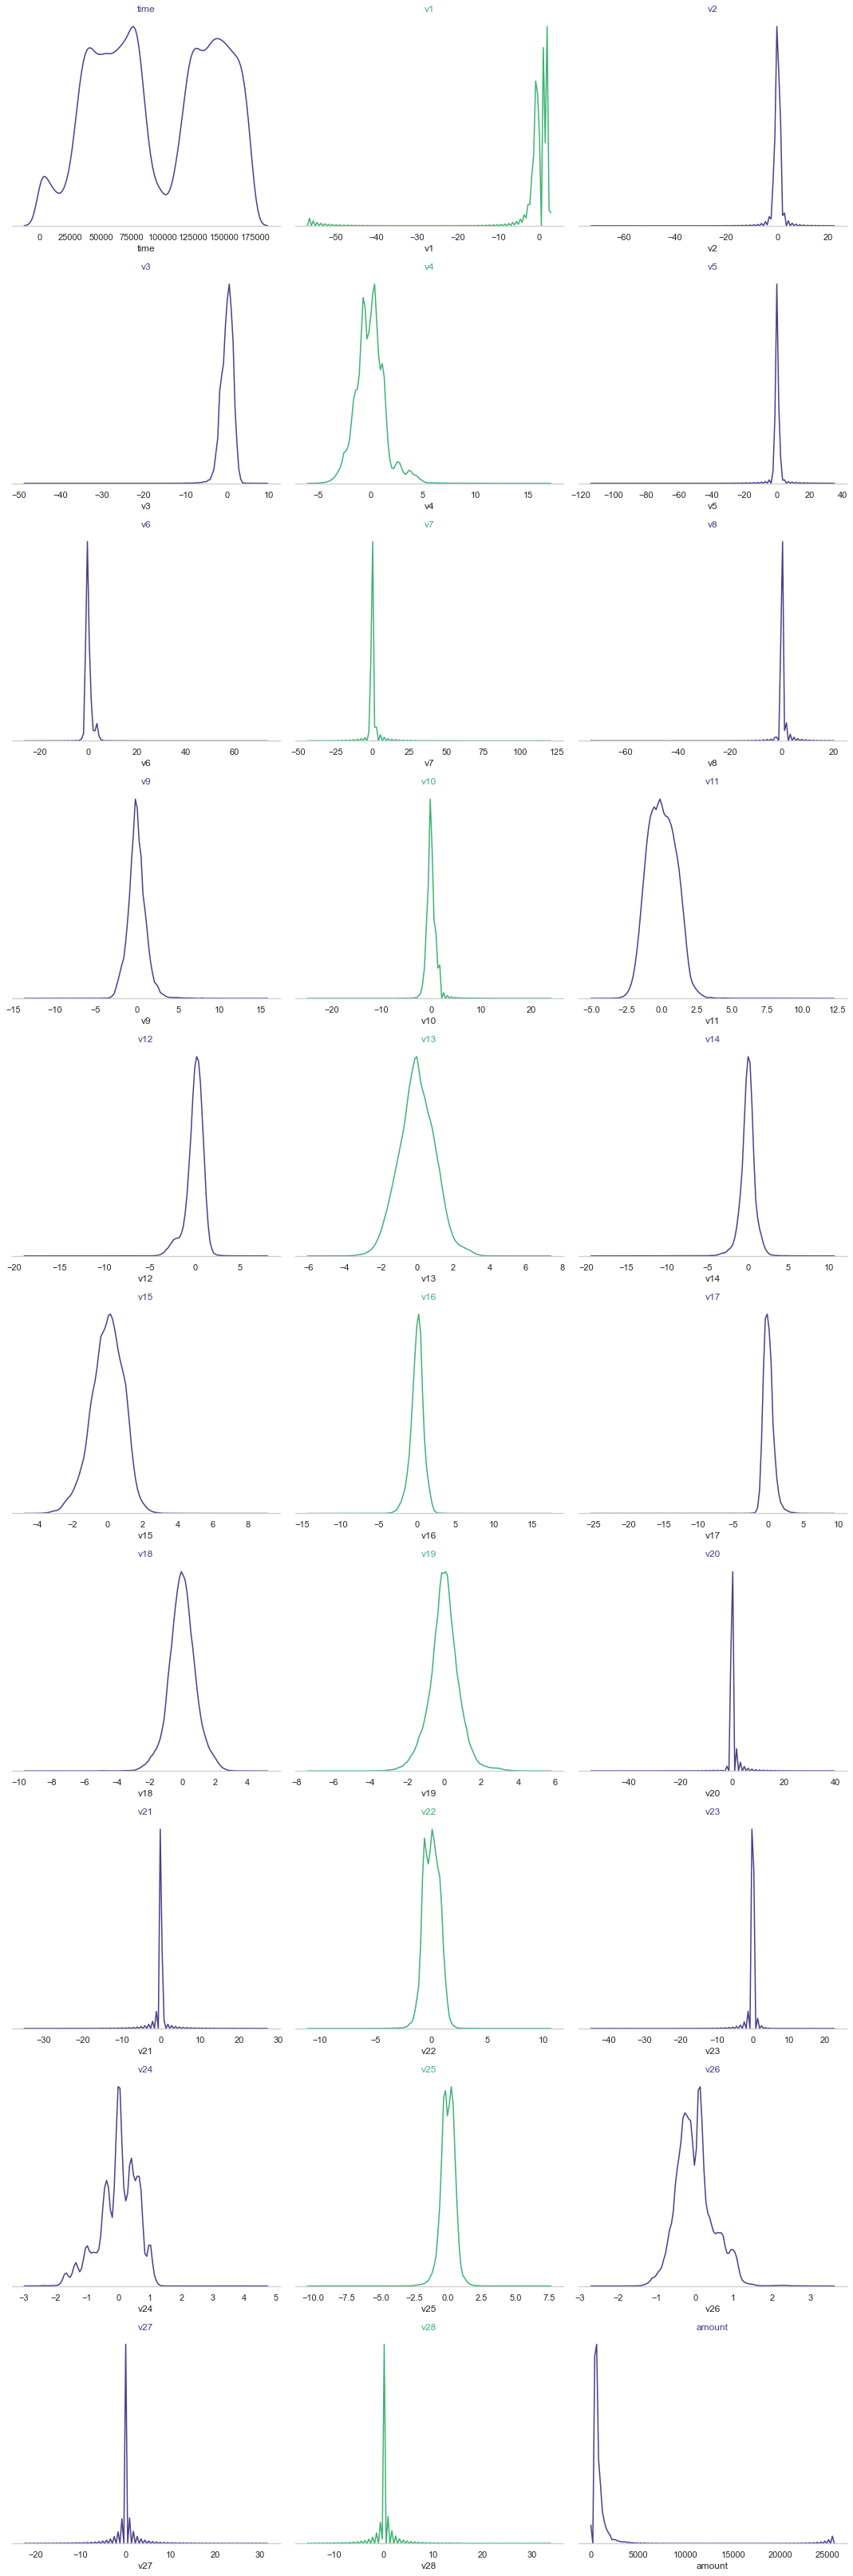

In [6]:
numplot_analysis(df_ori.drop('class', axis=1), fig_cols=3)

___
* _Pré-processing Pipeline_
___

In [7]:
# Features to be used on dataprep pipeline
features_ori = list(df_ori.drop('time', axis=1).columns)

# Construction a pre-processing pipeline from columns_transformers.py
pre_processing_pipe = Pipeline([
    ('selector', FeatureSelection(features=features_ori)),
    ('dup_dropper', DropDuplicates()),
    ('splitter', SplitData(target='class'))
])

# Executing the pipeline
X_train, X_test, y_train, y_test = pre_processing_pipe.fit_transform(df_ori)
model_features = list(X_train.columns)

# Looking at the results
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de y_train: {y_train.shape}')
print(f'\nDimensões de X_test: {X_test.shape}')
print(f'Dimensões de y_test: {y_test.shape}')

Dimensões de X_train: (220530, 29)
Dimensões de y_train: (220530,)

Dimensões de X_test: (55133, 29)
Dimensões de y_test: (55133,)


In [8]:
# Splitting the data by the dtype
num_attribs, cat_attribs = split_cat_num_data(X_train)
print(f'Total of numerical features: {len(num_attribs)}')
print(f'Total of categorical features: {len(cat_attribs)}')

Total of numerical features: 29
Total of categorical features: 0


# Modeling

___
* _Models: LogisticRegression, DecisionTrees, RandomForest and LightGBM_
___

In [9]:
# Preparing a dictionary to feed the ClassifiersAnalysis class
set_prep = {
    'X_train_prep': X_train.values,
    'X_test_prep': X_test.values,
    'y_train': y_train,
    'y_test': y_test
}

In [10]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Decision Trees hyperparameters
tree_param_grid = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [3, 5, 10, 20],
    'max_features': np.arange(1, X_train.shape[1]),
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# Random Forest hyperparameters
forest_param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50],
    'n_estimators': [50, 100, 200, 500],
    'random_state': [42],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

# LightGBM hyperparameters
lgbm_param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
}

lgbm_fixed_params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [11]:
# Preparando set de classificadores
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'DecisionTrees': {
        'model': DecisionTreeClassifier(),
        'params': tree_param_grid
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': forest_param_grid
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(**lgbm_fixed_params),
        'params': lgbm_param_grid
    }
}

___
* _Training each model selected with RandomizedSearchCV_
___

In [12]:
# Instanciando classe e treinando set de classificadores
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, cv=5, verbose=5)


Treinando modelo LogisticRegression
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 16.2min finished



Treinando modelo DecisionTrees
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished



Treinando modelo RandomForest
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 76.8min finished



Treinando modelo LightGBM
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


___
* _Evaluating on training and test data_
___

In [13]:
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
cm = sns.light_palette('cornflowerblue', as_cmap=True)
df_performances.reset_index(drop='True').style.background_gradient(cmap=cm)


Avaliando performance do modelo LogisticRegression

Avaliando performance do modelo DecisionTrees

Avaliando performance do modelo RandomForest

Avaliando performance do modelo LightGBM


,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.9773,0.0653,0.9083,0.1219,0.9743,675.162
1,LogisticRegression,Teste,0.9775,0.0612,0.8791,0.1144,0.9706,0.354
2,DecisionTrees,Treino 5 K-folds,0.9938,0.1998,0.8219,0.3199,0.91,175.86
3,DecisionTrees,Teste,0.9905,0.1274,0.8132,0.2202,0.9017,0.081
4,RandomForest,Treino 5 K-folds,0.9974,0.3907,0.8664,0.5356,0.9792,4367.75
5,RandomForest,Teste,0.997,0.3319,0.8242,0.4732,0.9706,1.461
6,LightGBM,Treino 5 K-folds,0.9982,0.37,0.0131,0.025,0.9762,74.846
7,LightGBM,Teste,0.9983,0,0,0,0.9632,0.531


___
* _Looking at the feature importance of a specific model_
___

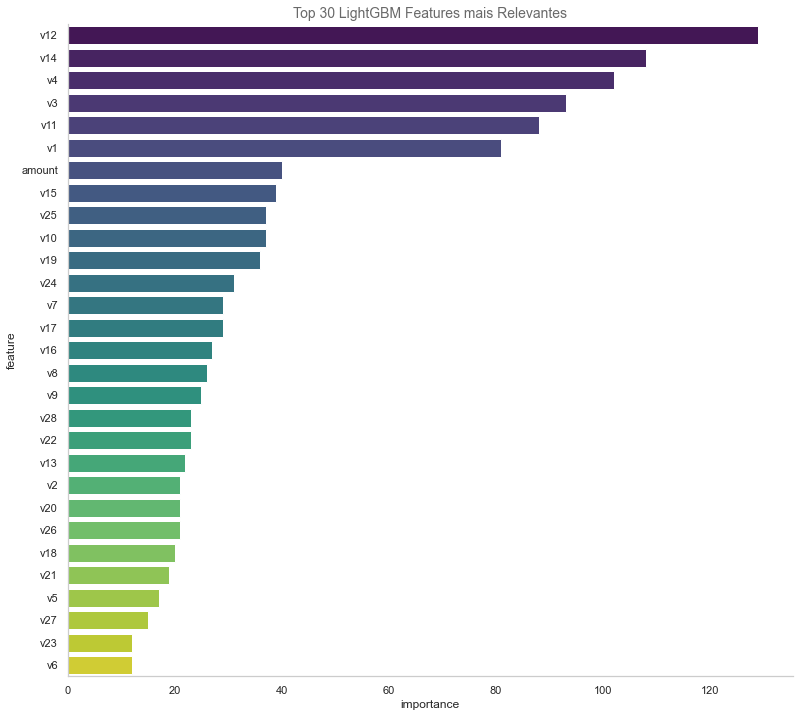

In [20]:
fig, ax = plt.subplots(figsize=(13, 12))
lgbm_feature_importance = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM', ax=ax)
plt.show()

___
* _ROC Curve for training and testing data_
___

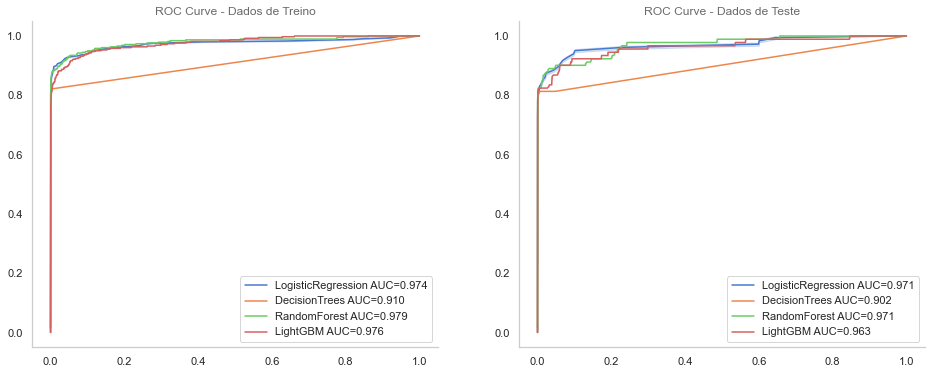

In [21]:
clf_tool.plot_roc_curve()

___
* _Score distributions on training and testing data_
___

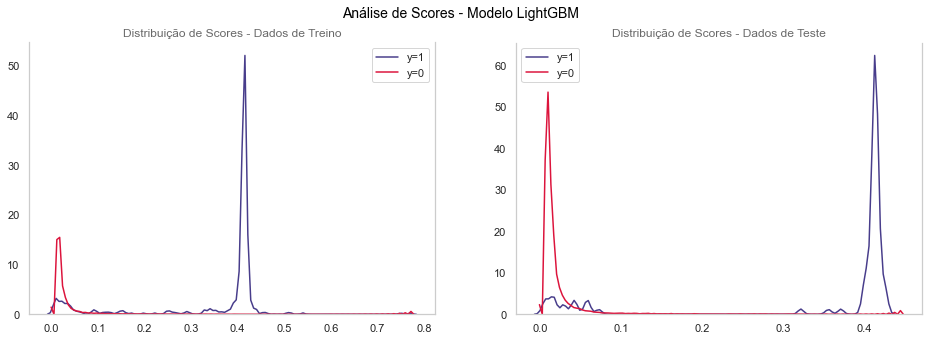

In [22]:
clf_tool.plot_score_distribution('LightGBM')

___
* _Splitting the probabilities on bins_
___

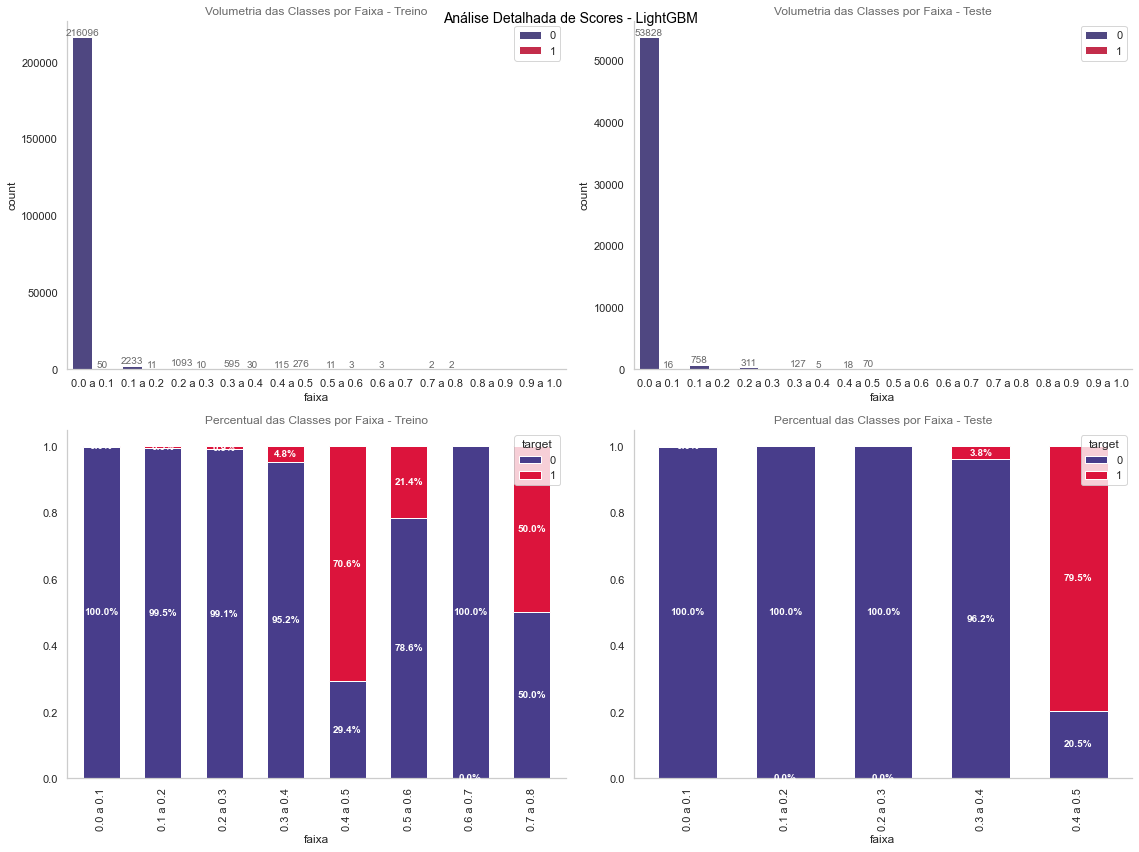

In [23]:
# Separação por faixa
clf_tool.plot_score_bins('LightGBM', bin_range=0.1)

## Undersampling

In [24]:
# Applying undersampling
rus = RandomUnderSampler()
X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

# Training new classifiers using undersampling
undersamp_approach= '_undersamp'
clf_tool.fit(set_classifiers, X_train_under, y_train_under, random_search=True, cv=5, approach=undersamp_approach)


Treinando modelo LogisticRegression_undersamp
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s



Treinando modelo DecisionTrees_undersamp
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  32 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



Treinando modelo RandomForest_undersamp
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.1s finished



Treinando modelo LightGBM_undersamp
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished


___
* _Evaluating on training and test data_
___

In [25]:
df_performances = clf_tool.evaluate_performance(X_train_under, y_train_under, X_test, y_test)
cm = sns.light_palette('cornflowerblue', as_cmap=True)
df_performances.reset_index(drop='True').style.background_gradient(cmap=cm)


Avaliando performance do modelo LogisticRegression_undersamp

Avaliando performance do modelo DecisionTrees_undersamp

Avaliando performance do modelo RandomForest_undersamp

Avaliando performance do modelo LightGBM_undersamp


,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.9773,0.0653,0.9083,0.1219,0.9743,675.162
1,LogisticRegression,Teste,0.9775,0.0612,0.8791,0.1144,0.9706,0.354
2,DecisionTrees,Treino 5 K-folds,0.9938,0.1998,0.8219,0.3199,0.91,175.86
3,DecisionTrees,Teste,0.9905,0.1274,0.8132,0.2202,0.9017,0.081
4,RandomForest,Treino 5 K-folds,0.9974,0.3907,0.8664,0.5356,0.9792,4367.75
5,RandomForest,Teste,0.997,0.3319,0.8242,0.4732,0.9706,1.461
6,LightGBM,Treino 5 K-folds,0.9982,0.37,0.0131,0.025,0.9762,74.846
7,LightGBM,Teste,0.9983,0,0,0,0.9632,0.531
8,LogisticRegression_undersamp,Treino 5 K-folds,0.941,0.9746,0.9057,0.9388,0.9808,0.104
9,LogisticRegression_undersamp,Teste,0.9775,0.061,0.8791,0.114,0.9679,0.076


___
* _ROC Curve for training and testing data_
___

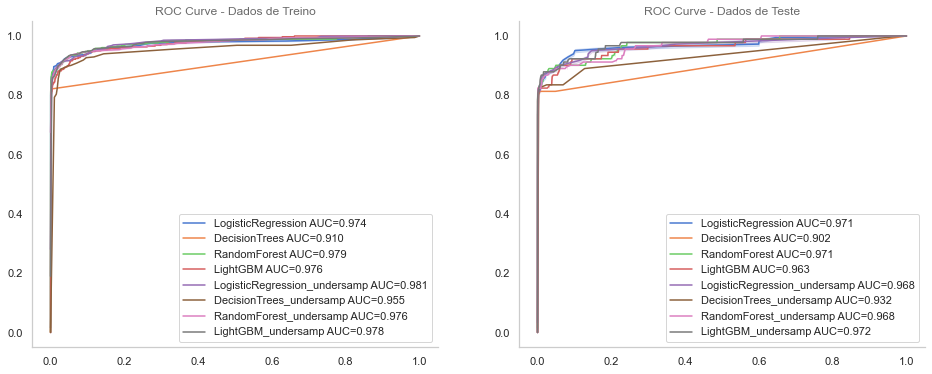

In [26]:
clf_tool.plot_roc_curve()

___
* _Score distributions on training and testing data_
___

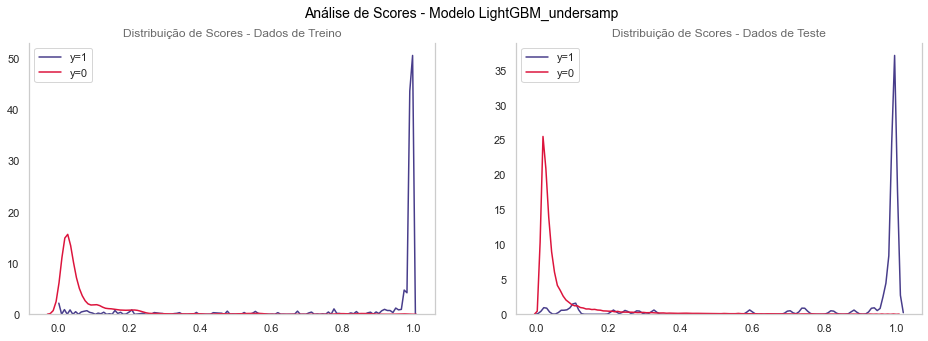

In [27]:
clf_tool.plot_score_distribution('LightGBM_undersamp')

___
* _Splitting the probabilities on bins_
___

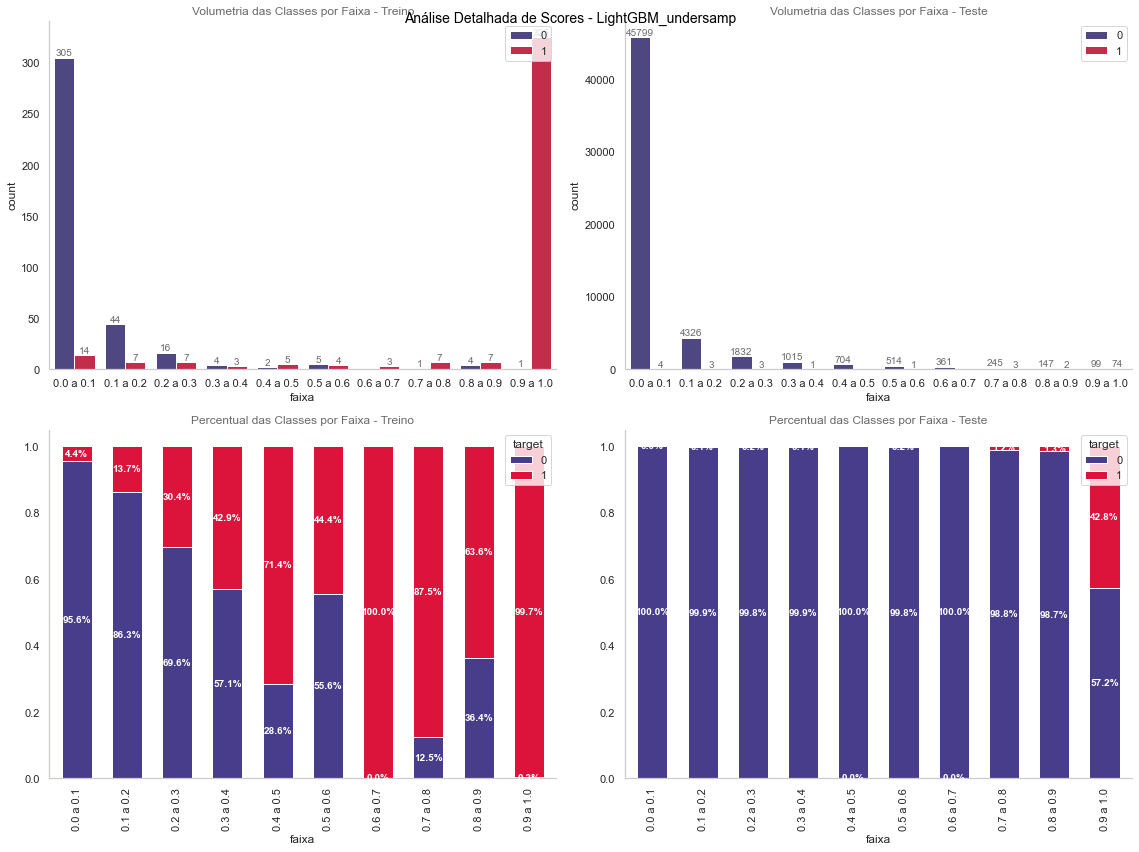

In [28]:
clf_tool.plot_score_bins('LightGBM_undersamp', bin_range=0.1)

## Oversampling

Let's change the set_classifiers dictionary to optimize time

In [29]:
lgbm_set_classifier = {}
lgbm_set_classifier['LightGBM'] = set_classifiers['LightGBM']

In [30]:
# Applying oversampling
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_over, y_train_over = sm.fit_sample(X_train, y_train)

# Treinando novo modelo após undersampling
oversamp_approach= '_oversamp'
clf_tool.fit(lgbm_set_classifier, X_train_over, y_train_over, random_search=True, cv=5, approach=oversamp_approach)


Treinando modelo LightGBM_oversamp
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


___
* _Evaluating on training and test data_
___

In [31]:
df_performances = clf_tool.evaluate_performance(X_train_over, y_train_over, X_test, y_test)
cm = sns.light_palette('cornflowerblue', as_cmap=True)
df_performances.reset_index(drop='True').style.background_gradient(cmap=cm)


Avaliando performance do modelo LightGBM_oversamp


,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.9773,0.0653,0.9083,0.1219,0.9743,675.162
1,LogisticRegression,Teste,0.9775,0.0612,0.8791,0.1144,0.9706,0.354
2,DecisionTrees,Treino 5 K-folds,0.9938,0.1998,0.8219,0.3199,0.91,175.86
3,DecisionTrees,Teste,0.9905,0.1274,0.8132,0.2202,0.9017,0.081
4,RandomForest,Treino 5 K-folds,0.9974,0.3907,0.8664,0.5356,0.9792,4367.75
5,RandomForest,Teste,0.997,0.3319,0.8242,0.4732,0.9706,1.461
6,LightGBM,Treino 5 K-folds,0.9982,0.37,0.0131,0.025,0.9762,74.846
7,LightGBM,Teste,0.9983,0,0,0,0.9632,0.531
8,LogisticRegression_undersamp,Treino 5 K-folds,0.941,0.9746,0.9057,0.9388,0.9808,0.104
9,LogisticRegression_undersamp,Teste,0.9775,0.061,0.8791,0.114,0.9679,0.076


___
* _ROC Curve for training and testing data_
___

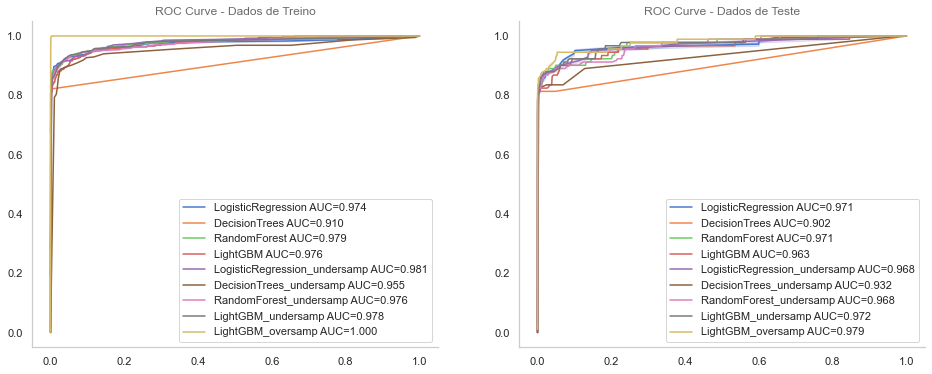

In [32]:
clf_tool.plot_roc_curve()

___
* _Score distributions on training and testing data_
___

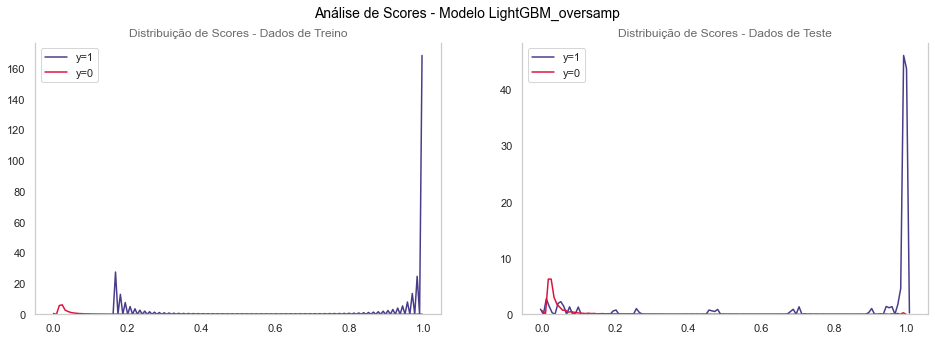

In [33]:
clf_tool.plot_score_distribution('LightGBM_oversamp')

___
* _Splitting the probabilities on bins_
___

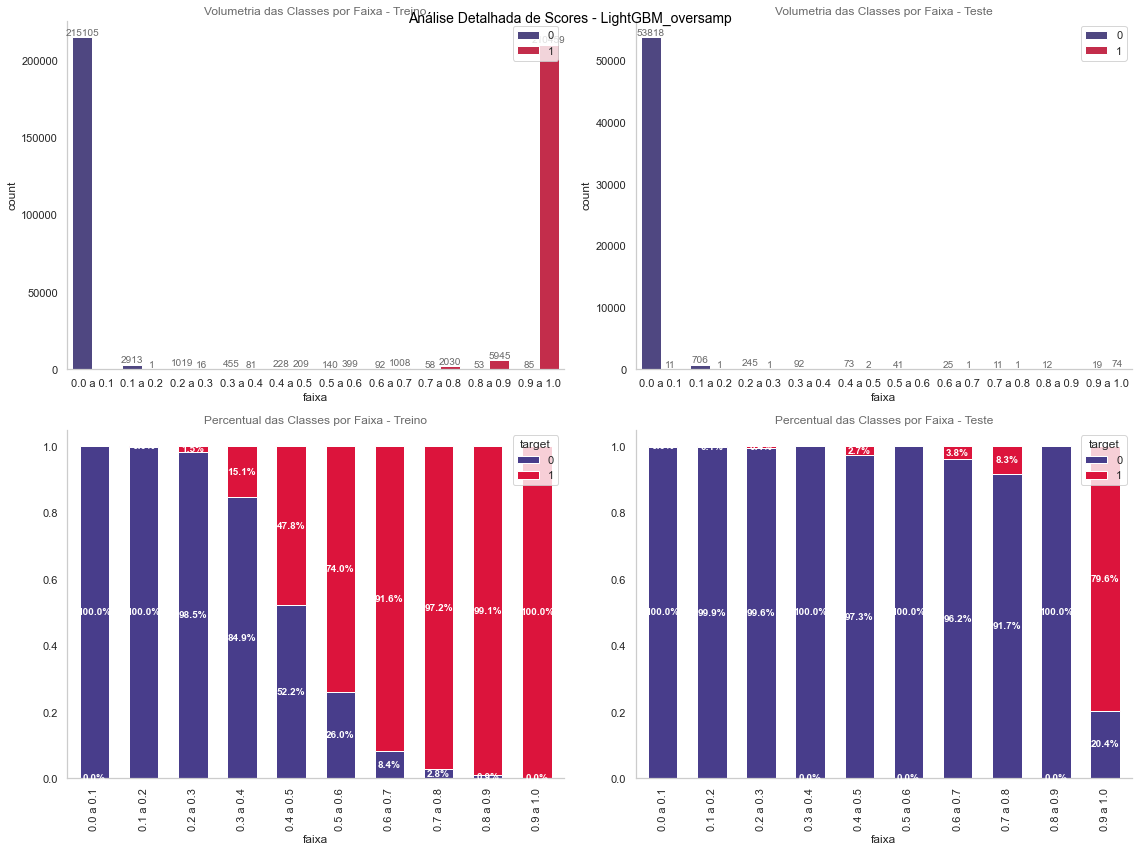

In [34]:
clf_tool.plot_score_bins('LightGBM_oversamp', bin_range=0.1)

Filtering the model/approach with highest AUC on test data:

In [35]:
df_performances.query('approach == "Teste"').sort_values(by='auc', ascending=False)

,model,approach,acc,precision,recall,f1,auc,total_time
0,LightGBM_oversamp,Teste,0.9978,0.4130,0.8352,0.5527,0.9790,0.915
0,LightGBM_undersamp,Teste,0.9750,0.0553,0.8791,0.1041,0.9722,0.530
0,LogisticRegression,Teste,0.9775,0.0612,0.8791,0.1144,0.9706,0.354
0,RandomForest,Teste,0.9970,0.3319,0.8242,0.4732,0.9706,1.461
0,LogisticRegression_undersamp,Teste,0.9775,0.0610,0.8791,0.1140,0.9679,0.076
0,RandomForest_undersamp,Teste,0.9690,0.0450,0.8791,0.0856,0.9679,1.917
0,LightGBM,Teste,0.9983,0.0000,0.0000,0.0000,0.9632,0.531
0,DecisionTrees_undersamp,Teste,0.9751,0.0530,0.8352,0.0997,0.9319,0.054
0,DecisionTrees,Teste,0.9905,0.1274,0.8132,0.2202,0.9017,0.081
